In [7]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.backends.backend_pdf
import collections

pd.options.mode.chained_assignment = None  # default='warn'
from statsmodels.stats import multitest
from scipy import stats

# ReadZs from 10Xv3 sequencing correlations with MOp MERFISH

In [8]:
#Pull directly from gene_cell table because I want to collapse per mouse (2 mice total)
mop_df = pd.read_csv('../outputs/gene_cell/MOp_periphal_ReadZs_gene_ontology.csv')

gb_cols = ['mouse','gene','ontology']

#filter SRRS results to
#1. Drop gene/cells which have fewer than 5 gene spots of interest
#2. Drop gene/cell-type/mouse with fewer than 20 cells
mop_df = mop_df[mop_df['num_gene_spots'].ge(5)]
mop_df = mop_df.groupby(gb_cols).filter(lambda g: len(g) >= 20)

#aggregate by mouse (over all slices)
#Calculate z from Lyapunov CLT for each gene in each sample
mop_agg_df = mop_df.groupby(gb_cols).agg(
    num_cells = ('cell_id','nunique'),
    num_slices = ('sample','nunique'),
    med_gene_spots = ('num_gene_spots','median'),
    med_spots = ('num_spots','median'),
    med_score = ('score','median'),
    score_sum = ('score','sum'),
    var_sum = ('variance','sum'),
).reset_index()

mop_agg_df['z'] = mop_agg_df['score_sum']/np.sqrt(mop_agg_df['var_sum'])

#Calculate two-sided p and BH correct ps
p_onesided = stats.norm.cdf(mop_agg_df['z'])
mop_agg_df['p'] = 2*np.minimum(p_onesided, 1-p_onesided)

alpha = 0.05

_,adj_p,_,_ = multitest.multipletests(
    mop_agg_df['p'],
    alpha = alpha,
    method = 'fdr_bh',
)
mop_agg_df['bh_p'] = adj_p
mop_agg_df = mop_agg_df.rename(columns={'mouse':'merfish_mouse'})
mop_agg_df

,merfish_mouse,gene,ontology,num_cells,num_slices,med_gene_spots,med_spots,med_score,score_sum,var_sum,z,p,bh_p
0,1,Acta2,L2/3 IT,991,5,5.0,695.0,0.102431,91.602118,122.242160,8.285048,2.220446e-16,8.804734e-16
1,1,Acta2,L5 ET,106,3,5.0,888.5,0.095434,9.724163,13.084333,2.688292,7.181856e-03,1.179307e-02
2,1,Acta2,L5 IT,817,5,6.0,836.0,0.125850,92.051336,97.079655,9.342562,0.000000e+00,0.000000e+00
3,1,Acta2,L6 CT,265,3,5.0,516.0,0.176113,39.580953,33.029954,6.887035,5.696776e-12,1.891902e-11
4,1,Acta2,L6 IT,448,5,5.0,781.5,0.167048,69.549196,54.999854,9.378024,0.000000e+00,0.000000e+00
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2509,2,Wnt7b,L5 ET,562,6,10.0,869.0,0.054671,25.664760,46.654497,3.757426,1.716700e-04,3.422509e-04
2510,2,Wnt7b,L5 IT,4906,6,18.0,636.0,0.052561,252.284730,275.239351,15.206725,0.000000e+00,0.000000e+00
2511,2,Wnt7b,L6 CT,1684,6,8.0,435.0,0.077132,111.832298,155.319639,8.973339,0.000000e+00,0.000000e+00
2512,2,Wnt7b,L6 IT,1053,6,8.0,661.0,0.083333,82.884489,97.084564,8.411979,0.000000e+00,0.000000e+00


In [9]:
#read in the 10X ReadZs gene-level dataset
rz_10x = pd.read_csv('../outputs/readzs/gene_level/MOp_10Xv3.csv')
rz_10x = rz_10x.rename(columns={'mouse':'readzs_mouse'})
rz_10x.head()

,window,ontology_mouse,sum_counts_per_window_per_ont,med_counts_per_window_per_ont,median_z_scaled,chi2_p_val,perm_p_val,significant,medians_range,ontology,readzs_mouse,chr,strand,gene,rz_bh_corrected
0,chr4_Rspo1_plus,Vip___426003,603,6.0,-0.091192,1.0,1.0,NaN,0.354532,Vip,426003,chr4,+,Rspo1,1.0
1,chr4_Rspo1_plus,L6 CT___426003,35,5.0,-0.079529,1.0,1.0,NaN,0.354532,L6 CT,426003,chr4,+,Rspo1,1.0
2,chr4_Rspo1_plus,L5 IT___426003,26900,8.0,0.107795,1.0,1.0,NaN,0.354532,L5 IT,426003,chr4,+,Rspo1,1.0
3,chr4_Rspo1_plus,L2/3 IT___426003,718,7.0,0.263340,1.0,1.0,NaN,0.354532,L2/3 IT,426003,chr4,+,Rspo1,1.0
4,chr4_Col15a1_plus,L5 IT___426003,1606,6.0,-0.117295,1.0,1.0,NaN,0.227648,L5 IT,426003,chr4,+,Col15a1,1.0


In [10]:
#merge the SRRS and ReadZs
m = mop_agg_df.merge(rz_10x, on=['gene','ontology'])
m.head()

,merfish_mouse,gene,ontology,num_cells,num_slices,med_gene_spots,med_spots,med_score,score_sum,var_sum,...,med_counts_per_window_per_ont,median_z_scaled,chi2_p_val,perm_p_val,significant,medians_range,readzs_mouse,chr,strand,rz_bh_corrected
0,1,Adamts2,L2/3 IT,56,2,6.0,814.5,-0.271203,-10.749388,6.583127,...,8.0,-0.020955,2.182229e-10,0.26,False,1.327871,457911,chr11,+,0.476667
1,1,Adamts2,L2/3 IT,56,2,6.0,814.5,-0.271203,-10.749388,6.583127,...,7.0,-0.088194,9.360248e-02,1.00,NaN,0.376036,427378,chr11,+,1.000000
2,2,Adamts2,L2/3 IT,194,5,6.0,820.5,-0.185677,-30.205382,22.374981,...,8.0,-0.020955,2.182229e-10,0.26,False,1.327871,457911,chr11,+,0.476667
3,2,Adamts2,L2/3 IT,194,5,6.0,820.5,-0.185677,-30.205382,22.374981,...,7.0,-0.088194,9.360248e-02,1.00,NaN,0.376036,427378,chr11,+,1.000000
4,1,Adamts2,L6 IT,137,3,6.0,727.0,-0.178947,-22.776114,15.504994,...,8.0,-0.038736,2.182229e-10,0.26,False,1.327871,457911,chr11,+,0.476667


In [11]:
#calculate pearson correlations and BH corrected p-values
corr_data = collections.defaultdict(list)

#don't correlate ReadZs/SRRS gene/samples/mice with too few ontologies
gene_sample_ontology_df = (
    m.groupby([
        'gene',
        'merfish_mouse',
        'readzs_mouse'
    ]).filter(
        lambda g: g['ontology'].nunique() >= 5)
)

for (gene,merfish_mouse,readzs_mouse),g in gene_sample_ontology_df.groupby(['gene','merfish_mouse','readzs_mouse']):
    r,p = stats.pearsonr(g['med_score'],g['median_z_scaled'])
    
    corr_data['gene'].append(gene)
    corr_data['merfish_mouse'].append(merfish_mouse)
    corr_data['readzs_mouse'].append(readzs_mouse)
    corr_data['num_celltypes'].append(g['ontology'].nunique())
    corr_data['med_SRRS_cells_per_celltype'].append(g['num_cells'].median())
    corr_data['pearson_r'].append(r)
    corr_data['pearson_p'].append(p)

#BH multiple hypothesis correction for correlation p-values
corr_df = pd.DataFrame(corr_data).sort_values('pearson_p')
_,adj_p,_,_ = multitest.multipletests(
    corr_df['pearson_p'],
    alpha = 0.05,
    method = 'fdr_bh',
)

corr_df['bh_pearson_p'] = adj_p
corr_df['significant'] = corr_df['bh_pearson_p'].le(0.05)

corr_df

,gene,merfish_mouse,readzs_mouse,num_celltypes,med_SRRS_cells_per_celltype,pearson_r,pearson_p,bh_pearson_p,significant
121,Timp3,1,426003,10,232.5,-0.930106,2.928203e-09,4.245894e-07,True
122,Timp3,1,427378,7,73.0,-0.961254,4.492778e-08,2.567374e-06,True
125,Timp3,2,427378,5,43.0,-0.989470,5.311808e-08,2.567374e-06,True
124,Timp3,2,426003,8,331.0,-0.932392,1.446074e-07,5.242017e-06,True
123,Timp3,1,457911,6,210.0,-0.948840,2.532262e-06,7.343560e-05,True
...,...,...,...,...,...,...,...,...,...
55,Nos1,1,427378,5,517.0,-0.023994,9.694534e-01,9.906024e-01,False
140,Ust,1,457911,9,661.0,-0.007354,9.768952e-01,9.906024e-01,False
59,Npnt,2,427378,5,1381.0,0.018113,9.769389e-01,9.906024e-01,False
49,Kcng1,2,427378,5,1678.0,-0.007607,9.903145e-01,9.928784e-01,False


In [12]:
#multiple genes have significant ReadZs/SRRS Pearson correlations between pairs of spatial/10X samples
sig_genes = corr_df[corr_df['significant']]['gene'].unique()
display(sig_genes)

corr_df[corr_df['significant']].sort_values('gene')

array(['Timp3', 'Cbln2', 'Ptpru', 'Itgb8', 'Ubash3b', 'Rgs5', 'Cobll1',
       'Ntng2'], dtype=object)

,gene,merfish_mouse,readzs_mouse,num_celltypes,med_SRRS_cells_per_celltype,pearson_r,pearson_p,bh_pearson_p,significant
10,Cbln2,2,427378,8,1474.0,0.699067,2.583638e-03,2.341422e-02,True
12,Cbln2,2,457911,6,2165.0,0.978275,7.028394e-04,8.492643e-03,True
11,Cbln2,2,457909,7,1849.0,0.855046,9.727602e-05,2.275496e-03,True
20,Cobll1,1,426003,5,939.0,0.972692,5.395007e-03,4.460751e-02,True
43,Itgb8,2,426003,7,706.0,0.823569,2.943266e-04,4.741929e-03,True
45,Itgb8,2,457909,6,877.0,0.858425,3.514448e-04,5.095950e-03,True
72,Ntng2,1,457909,6,2528.0,-0.938610,5.537484e-03,4.460751e-02,True
100,Ptpru,1,427378,7,1846.0,-0.943039,1.442140e-03,1.493645e-02,True
101,Ptpru,2,427378,8,1301.0,-0.964395,1.098515e-04,2.275496e-03,True
106,Rgs5,1,457909,5,652.0,-0.988062,1.563044e-03,1.510943e-02,True


In [13]:
ind_cols = ['gene','merfish_mouse','readzs_mouse']
sig_inds = corr_df[corr_df['significant']].set_index(ind_cols).index
sig_gene_sample_ontology_df = gene_sample_ontology_df.set_index(ind_cols).loc[sig_inds].reset_index()
sig_gene_sample_ontology_df

,gene,merfish_mouse,readzs_mouse,ontology,num_cells,num_slices,med_gene_spots,med_spots,med_score,score_sum,...,sum_counts_per_window_per_ont,med_counts_per_window_per_ont,median_z_scaled,chi2_p_val,perm_p_val,significant,medians_range,chr,strand,rz_bh_corrected
0,Timp3,1,426003,Astro,3842,6,9.0,163.0,0.114916,375.308898,...,313,6.0,0.120624,0.0,0.0,True,1.490912,chr10,+,0.0
1,Timp3,1,426003,Astro,3842,6,9.0,163.0,0.114916,375.308898,...,313,6.0,0.120624,0.0,0.0,True,1.490912,chr10,+,0.0
2,Timp3,1,426003,Endo,1689,6,11.0,160.0,-0.025641,-40.645735,...,394,8.0,0.818738,0.0,0.0,True,1.490912,chr10,+,0.0
3,Timp3,1,426003,Endo,1689,6,11.0,160.0,-0.025641,-40.645735,...,394,8.0,0.818738,0.0,0.0,True,1.490912,chr10,+,0.0
4,Timp3,1,426003,L2/3 IT,97,2,5.0,668.0,0.458955,36.342284,...,142,5.0,-0.496205,0.0,0.0,True,1.490912,chr10,+,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
202,Ntng2,1,457909,L5 IT,5874,6,10.0,644.0,-0.027560,-155.989082,...,5046,7.0,-0.023188,1.0,1.0,NaN,0.321235,chr2,-,1.0
203,Ntng2,1,457909,L6 CT,77,1,7.0,531.0,0.253503,16.280638,...,76,6.0,-0.267742,1.0,1.0,NaN,0.321235,chr2,-,1.0
204,Ntng2,1,457909,L6 IT,5306,6,11.0,589.0,-0.011200,-37.821115,...,4493,9.0,-0.052365,1.0,1.0,NaN,0.321235,chr2,-,1.0
205,Ntng2,1,457909,L6 IT Car3,1166,5,36.0,593.0,-0.014624,-13.798992,...,833,23.0,0.053493,1.0,1.0,NaN,0.321235,chr2,-,1.0


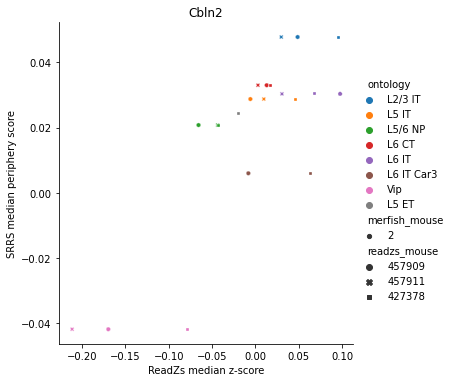

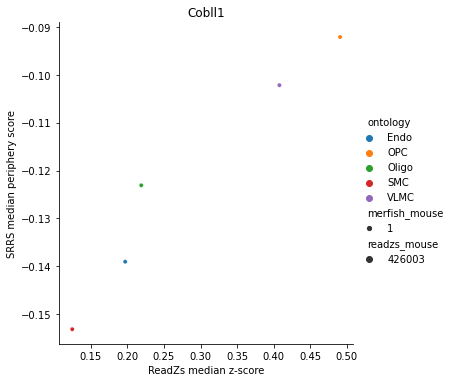

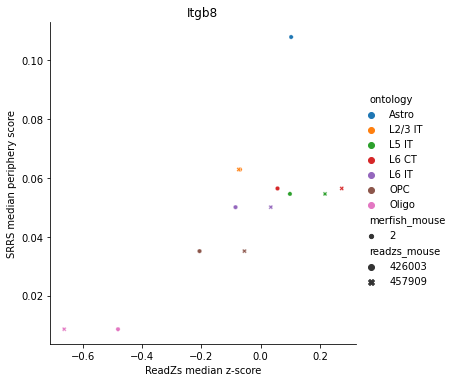

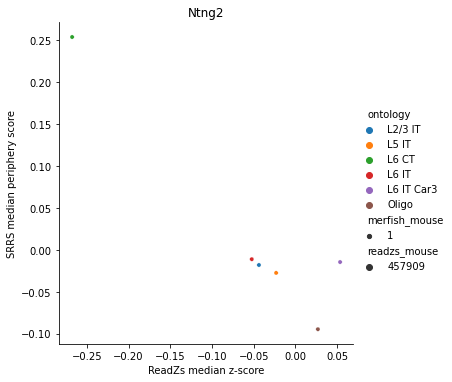

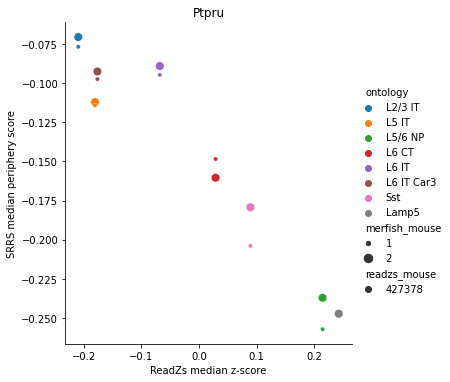

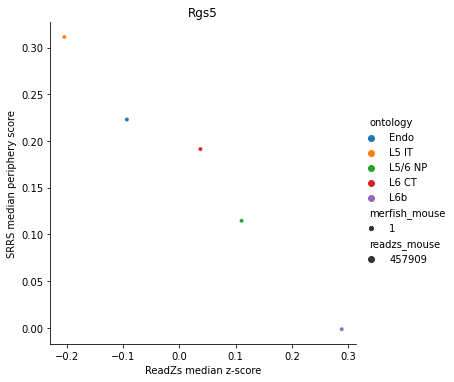

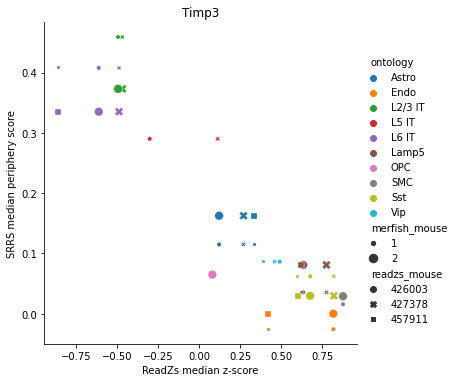

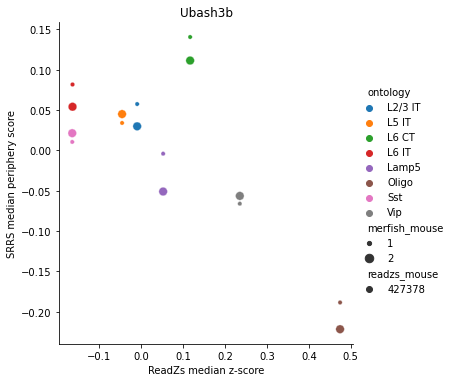

In [14]:
#all data on single plot

#pdf = matplotlib.backends.backend_pdf.PdfPages("significant_srrs_10X_readzs_correlations_by_mouse.pdf")

for gene,g in sig_gene_sample_ontology_df.groupby('gene'):
    g['readzs_mouse'] = g['readzs_mouse'].astype(str)
    
    sns.relplot(
        x = 'median_z_scaled',
        y = 'med_score',
        hue = 'ontology',
        size = 'merfish_mouse',
        style = 'readzs_mouse',
        data = g,
    )
    #plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.xlabel('ReadZs median z-score')
    plt.ylabel('SRRS median periphery score')
    plt.title('{}'.format(gene))
    #plt.tight_layout()
    plt.show()
    #pdf.savefig(bbox_inches='tight')
    plt.close()

#pdf.close()

# ReadZs SS2 correlations with SRRS MOp

In [19]:
#input is from the gene_cell table, grouped on ontologies matching SS2 dataset
#script is in ../analysis/mop_peripheral_to_rz_gene_annots.py
#also filtered:
#1. Dropped gene/cells which have fewer than 5 gene spots of interest
#2. Dropped gene/cell-type/samples with fewer than 20 cells

mop_ss2_df = pd.read_csv('../outputs/gene_ontology/MOp_periphal_ReadZs_SS2_gene_ontology.csv')
mop_ss2_df

,sample_id,gene,ontology,num_cells,med_gene_spots,med_spots,med_score,score_sum,var_sum,z,p,bh_p
0,m1s1,Acta2,L2/3 IT,397,6.0,611.0,0.087413,26.992258,46.958252,3.938975,8.183035e-05,3.007605e-04
1,m1s1,Acta2,L5 ET,51,6.0,698.0,0.032479,2.767631,6.067670,1.123562,2.611988e-01,3.703476e-01
2,m1s1,Acta2,L5 IT,257,6.0,654.0,0.094270,25.067569,29.188310,4.639891,3.485936e-06,1.570885e-05
3,m1s1,Acta2,L6 CT,26,5.0,304.0,0.176217,4.241585,3.271222,2.345164,1.901872e-02,4.149965e-02
4,m1s1,Acta2,L6 IT,85,6.0,569.0,0.035714,2.599184,10.194193,0.814068,4.156061e-01,5.297224e-01
...,...,...,...,...,...,...,...,...,...,...,...,...
10639,m2s6,Wnt7b,L2/3 IT,29,6.0,900.0,0.162105,1.361600,3.188962,0.762474,4.457772e-01,5.588096e-01
10640,m2s6,Wnt7b,L5 ET,85,9.0,884.0,0.070501,2.535220,7.512154,0.924982,3.549752e-01,4.705496e-01
10641,m2s6,Wnt7b,L5 IT,867,19.0,687.0,0.056877,51.876213,48.954780,7.414310,1.223466e-13,1.123604e-12
10642,m2s6,Wnt7b,L6 CT,248,8.0,464.0,0.017007,7.288136,23.892058,1.491041,1.359506e-01,2.196506e-01


In [20]:
rz_ss2 = pd.read_csv('../outputs/readzs/gene_level/MOp_SS2.csv')
rz_ss2.head()

,gene,window,ontology,sum_counts_per_window_per_ont,med_counts_per_window_per_ont,median_z_scaled,chi2_p_val,perm_p_val,significant,medians_range,rz_bh_corrected
0,Pxdc1,chr13_Pxdc1,Sncg,523,12.0,-0.188515,0.0,0.0,True,1.986624,0.0
1,Pxdc1,chr13_Pxdc1,Pvalb,1678,12.0,-0.096740,0.0,0.0,True,1.986624,0.0
2,Pxdc1,chr13_Pxdc1,Vip,16511,31.0,-0.094528,0.0,0.0,True,1.986624,0.0
3,Pxdc1,chr13_Pxdc1,Sst,17065,23.0,-0.093417,0.0,0.0,True,1.986624,0.0
4,Pxdc1,chr13_Pxdc1,L5 IT,3232,12.0,-0.076602,0.0,0.0,True,1.986624,0.0


In [21]:
#merge the SRRS and ReadZs
m = mop_ss2_df.merge(rz_ss2, on=['gene','ontology'])
m.head()

,sample_id,gene,ontology,num_cells,med_gene_spots,med_spots,med_score,score_sum,var_sum,z,...,bh_p,window,sum_counts_per_window_per_ont,med_counts_per_window_per_ont,median_z_scaled,chi2_p_val,perm_p_val,significant,medians_range,rz_bh_corrected
0,m1s1,Acta2,L2/3 IT,397,6.0,611.0,0.087413,26.992258,46.958252,3.938975,...,3.007605e-04,chr19_Acta2,156,2.0,-0.245706,0.0,0.0,True,1.211264,0.0
1,m1s2,Acta2,L2/3 IT,165,5.0,848.0,0.102431,19.878605,21.225991,4.314713,...,6.539875e-05,chr19_Acta2,156,2.0,-0.245706,0.0,0.0,True,1.211264,0.0
2,m1s3,Acta2,L2/3 IT,63,5.0,582.0,0.146667,7.314908,8.222803,2.550932,...,2.507764e-02,chr19_Acta2,156,2.0,-0.245706,0.0,0.0,True,1.211264,0.0
3,m1s4,Acta2,L2/3 IT,239,5.0,742.0,0.117647,30.568177,29.700841,5.608997,...,1.219643e-07,chr19_Acta2,156,2.0,-0.245706,0.0,0.0,True,1.211264,0.0
4,m1s5,Acta2,L2/3 IT,127,5.0,722.0,0.104851,6.848170,16.134274,1.704903,...,1.535710e-01,chr19_Acta2,156,2.0,-0.245706,0.0,0.0,True,1.211264,0.0


In [26]:
#calculate pearson correlations and BH corrected p-values
corr_data = {
    'gene':[],
    'sample_id':[],
    'num_celltypes':[],
    'med_SRRS_cells_per_celltype':[],
    'pearson_r':[],
    'pearson_p':[],
}

#can't correlate ReadZs/SRRS gene/samples with only a single ontology
gene_sample_ontology_df = m.groupby(['gene','sample_id']).filter(lambda g: g['ontology'].nunique() >= 2)

for (gene,sample_name),g in gene_sample_ontology_df.groupby(['gene','sample_id']):
    r,p = stats.pearsonr(g['med_score'],g['median_z_scaled'])
    
    corr_data['gene'].append(gene)
    corr_data['sample_id'].append(sample_name)
    corr_data['num_celltypes'].append(g['ontology'].nunique())
    corr_data['med_SRRS_cells_per_celltype'].append(g['num_cells'].median())
    corr_data['pearson_r'].append(r)
    corr_data['pearson_p'].append(p)

#BH multiple hypothesis correction
corr_df = pd.DataFrame(corr_data).sort_values('pearson_p')
_,adj_p,_,_ = multitest.multipletests(
    corr_df['pearson_p'],
    alpha = 0.05,
    method = 'fdr_bh',
)

corr_df['bh_pearson_p'] = adj_p
corr_df['significant'] = corr_df['bh_pearson_p'].le(0.05)

corr_df

,gene,sample_id,num_celltypes,med_SRRS_cells_per_celltype,pearson_r,pearson_p,bh_pearson_p,significant
977,Nr4a1,m2s5,8,430.5,0.985720,0.000007,0.012950,True
976,Nr4a1,m2s4,9,436.0,0.969174,0.000016,0.014771,True
970,Nr4a1,m1s4,8,732.0,0.974040,0.000043,0.025704,True
1052,Parm1,m2s5,10,189.5,0.900351,0.000382,0.123503,False
975,Nr4a1,m2s3,7,355.0,0.966331,0.000392,0.123503,False
...,...,...,...,...,...,...,...,...
587,Flt1,m2s1,2,188.5,1.000000,1.000000,1.000000,False
588,Flt1,m2s2,2,265.0,1.000000,1.000000,1.000000,False
589,Flt1,m2s3,2,68.0,-1.000000,1.000000,1.000000,False
1546,Syt10,m1s3,2,47.0,-1.000000,1.000000,1.000000,False


In [27]:
#only Nr4a1 is significant (and in multiple MOp samples)
corr_df[corr_df['significant']]

,gene,sample_id,num_celltypes,med_SRRS_cells_per_celltype,pearson_r,pearson_p,bh_pearson_p,significant
977,Nr4a1,m2s5,8,430.5,0.985720,0.000007,0.012950,True
976,Nr4a1,m2s4,9,436.0,0.969174,0.000016,0.014771,True
970,Nr4a1,m1s4,8,732.0,0.974040,0.000043,0.025704,True


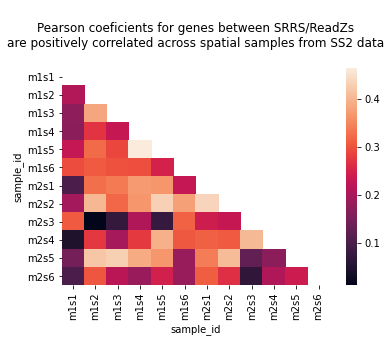

In [14]:
hm_df = corr_df.pivot(
    index='gene',
    columns='sample_id',
    values='pearson_r',
).corr()
mask = np.zeros_like(hm_df)
mask[np.triu_indices_from(mask)] = True

sns.heatmap(
    hm_df,
    mask=mask,
)
plt.title(
"""
Pearson coeficients for genes between SRRS/ReadZs
are positively correlated across spatial samples from SS2 data
"""
)
plt.show()
plt.close()

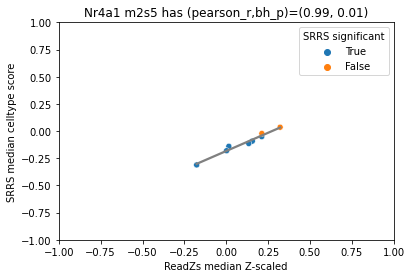

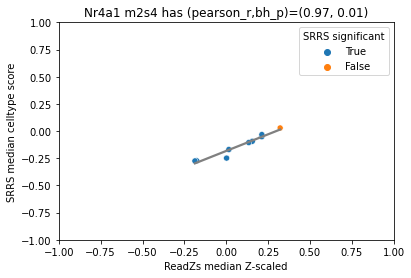

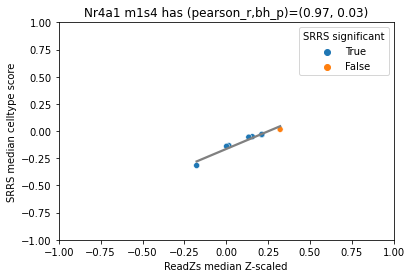

In [15]:
#pdf to save out to
pdf = matplotlib.backends.backend_pdf.PdfPages("significant_srrs_SS2_readzs_correlations.pdf")

for i,r in corr_df[corr_df['significant']].iterrows():
    gene,sample_name = r['gene'],r['sample_id']
    g = gene_sample_ontology_df[
        gene_sample_ontology_df['gene'].eq(gene) & gene_sample_ontology_df['sample_id'].eq(sample_name)
    ]
    
    g['SRRS significant'] = g['bh_p'].le(0.05).astype('str')
    
    
    fig = plt.figure()
    sns.scatterplot(
        x = 'median_z_scaled',
        y = 'med_score',
        hue = 'SRRS significant',
        hue_order = ['True','False'],
        data = g,
    )
    sns.regplot(
        x = 'median_z_scaled',
        y = 'med_score',
        color = 'grey',
        scatter = False,
        ci = None,
        data = g,
    )
    
    plt.xlabel('ReadZs median Z-scaled')
    plt.ylabel('SRRS median celltype score')
    plt.xlim(-1,1)
    plt.ylim(-1,1)
    plt.title('{} {} has (pearson_r,bh_p)=({:.2f}, {:.2f})'.format(
        gene,sample_name,r['pearson_r'],r['bh_pearson_p']))
    
    plt.show()
    pdf.savefig(fig)
    plt.close()
    
pdf.close()

In [40]:
#Flt1 not found in 10X data
#Previously it WAS found
#DIFFERENCE WAS THAT Flt1 is a minus-strand gene, but the significant bin was the plus strand
rz_10x['gene'].eq('Flt1').any()

False

In [35]:
#Flt1 found in SS2 (unstranded) but not significant
rz_ss2[rz_ss2['gene'].eq('Flt1')]

,gene,window,ontology,sum_counts_per_window_per_ont,med_counts_per_window_per_ont,median_z_scaled,chi2_p_val,perm_p_val,significant,medians_range,rz_bh_corrected
336,Flt1,chr5_Flt1,Lamp5,71,2.0,-0.599768,1.324658e-09,0.34,False,1.056614,0.408687
337,Flt1,chr5_Flt1,Endo,14835,862.0,0.026730,1.324658e-09,0.34,False,1.056614,0.408687
338,Flt1,chr5_Flt1,L6b,679,2.0,0.060212,1.324658e-09,0.34,False,1.056614,0.408687
339,Flt1,chr5_Flt1,L5 IT,329,1.0,0.167881,1.324658e-09,0.34,False,1.056614,0.408687
340,Flt1,chr5_Flt1,L6 IT,162,1.0,0.176370,1.324658e-09,0.34,False,1.056614,0.408687
341,Flt1,chr5_Flt1,Sst,128,2.0,0.176800,1.324658e-09,0.34,False,1.056614,0.408687
342,Flt1,chr5_Flt1,L6 CT,416,1.0,0.181648,1.324658e-09,0.34,False,1.056614,0.408687
343,Flt1,chr5_Flt1,L5/6 NP,35,1.0,0.183569,1.324658e-09,0.34,False,1.056614,0.408687
344,Flt1,chr5_Flt1,Pvalb,32,1.0,0.183784,1.324658e-09,0.34,False,1.056614,0.408687
345,Flt1,chr5_Flt1,L2/3 IT,64,1.0,0.185289,1.324658e-09,0.34,False,1.056614,0.408687


In [53]:
#checking if any windows in Flt1 are found to be significant on the minus strand
#not found no
#but also not found on the plus strand... which is weird because a plus strand Flt1 gene-bin was found...
#maybe there are filters that cause this bin to be removed from consideration?
#

window_size = 5000

rz_window_10X = pd.read_csv(
    '/oak/stanford/groups/horence/rob/isoform_localizations/SRRS/outputs/readzs/window_level/MOp_10Xv3.csv'
)
rz_window_10X['chr'] = rz_window_10X['window'].str.split('_').str[0]
rz_window_10X['bin_num'] = rz_window_10X['window'].str.split('_').str[1].astype(int)
rz_window_10X['strand'] = rz_window_10X['window'].str.split('_').str[2]

rz_window_10X = rz_window_10X[rz_window_10X['chr'].eq('chr5') & rz_window_10X['strand'].eq('minus')]

flt1_start = 147561604
flt1_end =   147726011

min_window = flt1_start//window_size
max_window = flt1_end//window_size

rz_window_10X = rz_window_10X[
    rz_window_10X['bin_num'].between(min_window-1,max_window+1)
]

rz_window_10X.head()

,window,ontology,sum_counts_per_window_per_ont,med_counts_per_window_per_ont,median_z_scaled,chi2_p_val,perm_p_val,significant,medians_range,rz_bh_corrected,chr,bin_num,strand


In [49]:
29512*5000

147560000

In [46]:
min_window

29512

In [47]:
max_window

29545

In [16]:
#Checking where Timp3 (a strong hit from 10X-ReadZs) wound up in the SS2-ReadZs
m[m['gene'].eq('Timp3')]

,sample_id,gene,ontology,num_cells,med_gene_spots,med_spots,med_score,score_sum,var_sum,z,...,bh_p,window,sum_counts_per_window_per_ont,med_counts_per_window_per_ont,median_z_scaled,chi2_p_val,perm_p_val,significant,medians_range,rz_bh_corrected
6182,m1s1,Timp3,Astro,373,9.0,154.0,0.106383,30.445873,31.042940,5.464457,...,2.681653e-07,chr10_Timp3,2021,156.0,0.492182,0.0,0.0,True,1.69275,0.0
6183,m1s2,Timp3,Astro,957,10.0,175.0,0.118644,100.699432,77.766428,11.419076,...,0.000000e+00,chr10_Timp3,2021,156.0,0.492182,0.0,0.0,True,1.69275,0.0
6184,m1s3,Timp3,Astro,471,8.0,157.0,0.096774,44.320020,42.841325,6.771245,...,1.032695e-10,chr10_Timp3,2021,156.0,0.492182,0.0,0.0,True,1.69275,0.0
6185,m1s4,Timp3,Astro,938,9.0,170.0,0.122585,93.737250,80.752185,10.431219,...,0.000000e+00,chr10_Timp3,2021,156.0,0.492182,0.0,0.0,True,1.69275,0.0
6186,m1s5,Timp3,Astro,732,9.0,167.0,0.121514,78.715069,61.510829,10.036495,...,0.000000e+00,chr10_Timp3,2021,156.0,0.492182,0.0,0.0,True,1.69275,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9209,m1s2,Timp3,Lamp5,20,7.0,758.5,0.005204,0.108001,2.085200,0.074792,...,9.594907e-01,chr10_Timp3,11487,28.0,0.216697,0.0,0.0,True,1.69275,0.0
9210,m1s5,Timp3,Lamp5,20,7.5,722.0,0.077545,1.850925,2.036065,1.297158,...,2.935614e-01,chr10_Timp3,11487,28.0,0.216697,0.0,0.0,True,1.69275,0.0
9211,m2s2,Timp3,Lamp5,22,6.0,680.5,0.149046,2.102929,2.614918,1.300456,...,2.923093e-01,chr10_Timp3,11487,28.0,0.216697,0.0,0.0,True,1.69275,0.0
9212,m2s4,Timp3,Lamp5,21,8.0,835.0,0.064433,1.898908,2.038134,1.330110,...,2.806967e-01,chr10_Timp3,11487,28.0,0.216697,0.0,0.0,True,1.69275,0.0


In [17]:
corr_df[corr_df['gene'].eq('Timp3')]

,gene,sample_id,num_celltypes,med_SRRS_cells_per_celltype,pearson_r,pearson_p,bh_pearson_p,significant
1621,Timp3,m1s2,10,109.5,-0.810892,0.004423,0.248507,False
1623,Timp3,m1s4,8,237.5,-0.769471,0.025577,0.446158,False
1629,Timp3,m2s4,7,253.0,-0.649378,0.114470,0.728628,False
1627,Timp3,m2s2,7,247.0,-0.582275,0.170166,0.818071,False
1624,Timp3,m1s5,7,376.0,-0.490666,0.263558,0.906074,False
1630,Timp3,m2s5,4,221.5,0.352702,0.647298,1.000000,False
1628,Timp3,m2s3,4,137.5,0.301327,0.698673,1.000000,False
1626,Timp3,m2s1,4,191.0,0.272069,0.727931,1.000000,False
1622,Timp3,m1s3,4,300.0,0.245582,0.754418,1.000000,False
1625,Timp3,m1s6,5,187.0,0.113002,0.856428,1.000000,False
